In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from altaipony.injrecanalysis import plot_heatmap, tile_up_injection_recovery

from funcs.helper import write_flares_to_file, read_custom_aperture_lc
from funcs.custom_detrending import custom_detrending

### Read a light curve from file

In [2]:
path = 'data/177ca_tess2019102508525-s0012-0000000449671564-0000-s_lc.fits'

In [3]:
flc = read_custom_aperture_lc(path, typ="custom")

# alternatively, read a generic light curve
# flc = read_custom_aperture_lc(path, typ="generic", mission="TESS", mode="LC")

# De-trend the light curve
flcd = flc.detrend("custom", func=custom_detrending)

# alternatively, use a generic method, like a Savitzky-Golay filter
# flcd = flc.detrend("savgol")

# Find flares in the detrended light curve
flcd = flcd.find_flares()

/work1/eilin/Flares_in_Clusters_2/RESULTS_Github/flares-in-clusters-with-k2-ii/flaresinclustersii/lib64/python3.6/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.FileIO name='data/177ca_tess2019102508525-s0012-0000000449671564-0000-s_lc.fits' mode='rb' closefd=True>
  """Entry point for launching an IPython kernel.
/work1/eilin/Flares_in_Clusters_2/RESULTS_Github/flares-in-clusters-with-k2-ii/flaresinclustersii/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
NumExpr defaulting to 8 threads.
Found 1 candidate(s) in the (0,9646) gap.
Found 1 candidate(s) in the (9646,18704) gap.
/work1/eilin/Flares_in_Clusters_2/RESULTS_Github/flares-in-clusters-with-k2-ii/flaresinclustersii/lib64/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept

In [4]:
flcd.flares

,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,total_n_valid_data_points,tstart,tstop
0,0.024531,293443,293446,7.367099,0.638922,6848,6851,18704.0,1635.017269,1635.021436
1,0.039327,304897,304901,11.984715,0.613684,17435,17439,18704.0,1650.925377,1650.930933


# Injection and recovery of synthetic flares

Following the instructions in the AltaiPony [docs](https://altaipony.readthedocs.io/en/latest/api/fakeflares.html).

In [5]:
flce, fake_flc = flcd.sample_flare_recovery(inject_before_detrending=True, mode="custom",
                                                func=custom_detrending,
                                                iterations=20, fakefreq=1e-3, ampl=[1e-2, .1],
                                                 dur=[5e-4, 0.2], save=False)


/work1/eilin/Flares_in_Clusters_2/RESULTS_Github/flares-in-clusters-with-k2-ii/flaresinclustersii/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
N/A%|                                                                         |
Detrending fake LC:

Found 2 candidate(s) in the (0,9346) gap.
Found 2 candidate(s) in the (9346,18106) gap.
  5%|###                                                                      |
Detrending fake LC:

Found 3 candidate(s) in the (0,9346) gap.
Found 2 candidate(s) in the (9346,18106) gap.
 10%|#######                                                                  |
Detrending fake LC:

Found 2 candidate(s) in the (0,9346) gap.
Found 2 candidate(s) in the (9346,18106) gap.
 15%|##########                                                               |
Detrending fake LC:

Found 3 candidate(s) in the (0,9346) gap.
Found 2 candidate(s) in the (9346,181

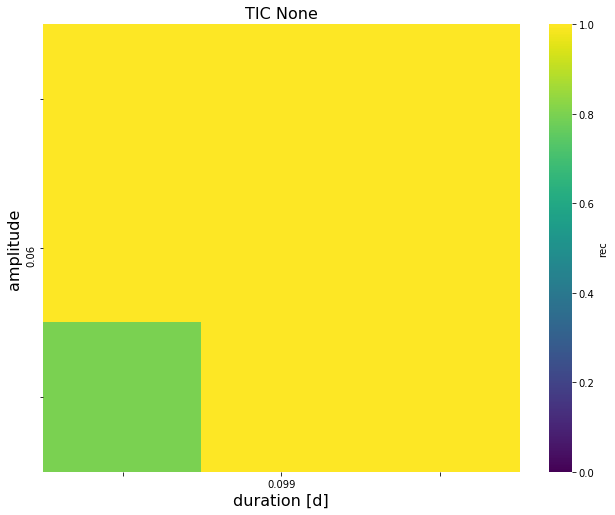

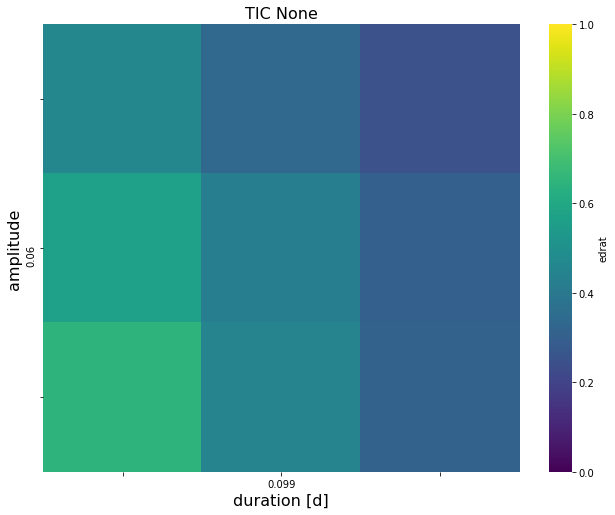

In [9]:
bins = 3
df = flce.fake_flares
dff, val = tile_up_injection_recovery(df, "recovery_probability",ampl_bins=bins, dur_bins=bins,)
plot_heatmap(dff, val, ID="some id");
dff, val = tile_up_injection_recovery(df, "ed_ratio",ampl_bins=bins, dur_bins=bins,)
plot_heatmap(dff, val, ID="some id");

In [13]:
flce = flce.characterize_flares(ampl_bins=bins, dur_bins=bins)
flce.flares.sort_values(by="ampl_rec").head().T

,0,1
ampl_rec,0.0245314,0.0393271
cstart,293443,304897
cstop,293446,304901
ed_rec,7.3671,11.9847
ed_rec_err,0.638922,0.613684
istart,6848,17435
istop,6851,17439
total_n_valid_data_points,18704,18704
tstart,1635.02,1650.93
tstop,1635.02,1650.93


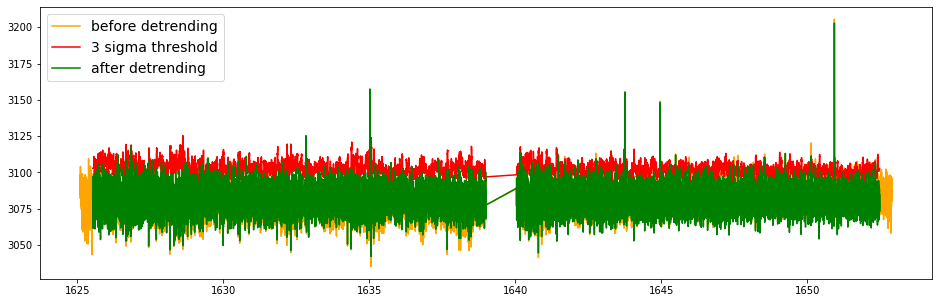

In [24]:
plt.figure(figsize=(16,5))
plt.plot(flc.time, flc.flux, c="orange",  label="before detrending");
plt.plot(flce.time, flce.it_med+3*flce.detrended_flux_err, c="r", label="3 sigma threshold");
plt.plot(flce.time, flce.detrended_flux, c="g", label="after detrending");

# uncomment to see either of the two flares
#plt.xlim(1634.8,1635.3)
#plt.xlim(1650.5,1651.5)

plt.legend(fontsize=14);